In [1]:
import os
import random
import zipfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread

import tensorflow as tf
from tensorflow.keras import layers, models, losses, optimizers
from tensorflow.keras.metrics import MeanIoU

from sklearn.model_selection import train_test_split

from google.colab import drive, runtime

# Mount Google Drive
drive.mount('/content/drive')

import sys
sys.path.insert(0, '/content/drive/MyDrive/Lung_Segmentation/scripts')
import lung_seg_utils






Mounted at /content/drive


# **Lung Segmentation with GAN-Enhanced U-Net**

## Project Overview
This project implements lung segmentation from chest X-ray images using a U-Net architecture enhanced with Generative Adversarial Network (GAN) training. The goal is to accurately segment lung regions across different pathological conditions.

## Dataset
- **Categories**: Normal, COVID, Viral Pneumonia, Lung Opacity
- **Input**: 256x256 grayscale chest X-ray images
- **Output**: Binary segmentation masks (lung vs. background)
- **Split**: Stratified train/validation/test split to ensure balanced representation across all disease categories

## Model Architecture

### U-Net Generator
- **Encoder**: Progressively downsamples images while extracting hierarchical features
 - Conv blocks with ReLU activation
 - MaxPooling for downsampling
 - Feature channels: 64 → 128 → 256 → 512 → 1024
- **Bridge**: Bottleneck layer with highest-level abstract features
- **Decoder**: Upsamples while preserving fine details
 - Conv2DTranspose for upsampling
 - Skip connections concatenate encoder features with decoder features
 - Gradually reduces channels: 512 → 256 → 128 → 64
- **Output**: Single channel with sigmoid activation for binary segmentation

### GAN Enhancement
- **Discriminator**: CNN that distinguishes real masks from generated masks
- **Adversarial Training**:
 - Generator loss = Adversarial loss + 100 × L1 loss
 - L1 loss ensures pixel-wise accuracy
 - Adversarial loss improves mask realism and boundary sharpness

## Key Technical Features

### Skip Connections
- Direct connections from encoder to decoder at matching resolutions
- Preserves fine spatial details lost during downsampling
- Critical for precise boundary delineation in medical segmentation

### Data Augmentation
- Horizontal flips and rotations (0°, 90°, 180°, 270°)
- Brightness and contrast adjustments
- Gaussian noise injection
- Random scaling (0.8x to 1.2x)
- Ensures model robustness across different image variations

### Training Strategy
- **Phase 1**: Standard U-Net training with binary crossentropy
- **Phase 2**: GAN training with adversarial loss + L1 regularization
- Early stopping with validation IoU monitoring
- Model checkpointing for best performance

## Results
- **Baseline U-Net**:
 - Test Jaccard Score: 0.9687
 - Test Accuracy: 0.9924
- **GAN-Enhanced U-Net**:
 - Test Jaccard Score: 0.9757
 - Test Accuracy: 0.9941

## Key Insights
The GAN enhancement provided modest but consistent improvements in segmentation quality, particularly in boundary precision. The adversarial training helps generate more realistic lung boundaries while the L1 loss maintains pixel-wise accuracy. This approach is particularly valuable for medical imaging where precise anatomical boundaries are critical for clinical applications.

# **Unzip `Covid-19 Radiography Database` data**

In [2]:
lung_seg_utils.retrieve_and_process_data()
main_dir='/content/data'
drive_dir='/content/drive/MyDrive'
data_dir=os.path.join(drive_dir,'Lung_Segmentation')
models_dir=os.path.join(data_dir,'models')
base=os.path.join(main_dir,"COVID-19_Radiography_Dataset")
subfolders=['Normal','COVID','Viral Pneumonia','Lung_Opacity']
S=0
size_dict={}
for folder in subfolders:
    print(folder)
    print( f'\tSize: {len(os.listdir(os.path.join(base,folder,"masks")))}')
    size_dict[folder]=len(os.listdir(os.path.join(base,folder,"masks")))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Successfully extracted all files from COVID-19_Radiography_Dataset.zip to /content/data
Normal
	Size: 10192
COVID
	Size: 3616
Viral Pneumonia
	Size: 1345
Lung_Opacity
	Size: 6012


# **Build U-Net Model**

In [3]:
# U-Net model definition
def conv_block(inputs, filters):
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(inputs)
    x = layers.Conv2D(filters, 3, padding='same', activation='relu')(x)
    return x

def encoder_block(inputs, filters):
    x = conv_block(inputs, filters)
    p = layers.MaxPooling2D(2)(x)
    return x, p

def decoder_block(inputs, skip_features, filters):
    x = layers.Conv2DTranspose(filters, 2, strides=2, padding='same')(inputs)
    x = layers.Concatenate()([x, skip_features])
    x = conv_block(x, filters)
    return x

def build_unet(input_shape, num_classes):
    inputs = layers.Input(input_shape)

    # Encoder
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    # Bbridge
    b1 = conv_block(p4, 1024)

    # decoder
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    outputs = layers.Conv2D(num_classes, 1, padding='same', activation='sigmoid')(d4)

    model = models.Model(inputs, outputs, name="U-Net")
    return model


def augment(image, mask):
    # Random horizontal flip
    if tf.random.uniform(()) > 0.5:
        image = tf.image.flip_left_right(image)
        mask = tf.image.flip_left_right(mask)

    # Random rotation by 0, 90, 180, or 270 degrees
    k = tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
    image = tf.image.rot90(image, k=k)
    mask = tf.image.rot90(mask, k=k)

    # Random brightness and contrast adjustment
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)

    # Add Gaussian noise
    noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=0.05)
    image = image + noise

    # Random zoom in/out (scaling)
    if tf.random.uniform(()) > 0.5:
        scales = list(np.arange(0.8, 1.2, 0.1))
        scale = random.choice(scales)
        new_size = tf.cast(tf.shape(image)[0:2] * scale, tf.int32)
        image = tf.image.resize(image, new_size)
        mask = tf.image.resize(mask, new_size)

    # Make sure pixel values stay in [0,1]
    image = tf.clip_by_value(image, 0, 1)
    mask = tf.clip_by_value(mask, 0, 1)

    return image, mask






# **Split Data**
Create training, validation, and testing data

In [5]:
paths = [
        (os.path.join(base, 'Lung_Opacity', 'images'), os.path.join(base, 'Lung_Opacity', 'masks')),
        (os.path.join(base, 'Normal', 'images'), os.path.join(base, 'Normal', 'masks')),
        (os.path.join(base, 'COVID', 'images'), os.path.join(base, 'COVID', 'masks')),
        (os.path.join(base, 'Viral Pneumonia', 'images'), os.path.join(base, 'Viral Pneumonia', 'masks'))
    ]

image_fnames=[]
mask_fnames=[]
dirs=[]
mask_dir=[]

for image_directory, mask_directory in paths:
    for image_filename, mask_filename in zip(sorted(os.listdir(image_directory)), sorted(os.listdir(mask_directory))):
        image_fnames.append(image_filename)
        mask_fnames.append(mask_filename)
        dirs.append(image_directory)
        mask_dir.append(mask_directory)
fnames_df=pd.DataFrame({'Image_Filename':image_fnames,'Mask_Filename': mask_fnames,'Image_Directory':dirs,'Mask_Directory':mask_dir})
train_fnames,test_set=train_test_split(fnames_df,stratify=fnames_df['Image_Directory'],test_size=0.20,random_state=42)
train_fnames,val_fnames=train_test_split(train_fnames,stratify=train_fnames['Image_Directory'],test_size=0.20,random_state=42)
train_fnames

Image_Filename             Mask_Filename  \
5620       Lung_Opacity-646.png      Lung_Opacity-646.png   
9014            Normal-3527.png           Normal-3527.png   
11897           Normal-6121.png           Normal-6121.png   
20107  Viral Pneumonia-1257.png  Viral Pneumonia-1257.png   
16173           Normal-9971.png           Normal-9971.png   
...                         ...                       ...   
6338            Normal-1118.png           Normal-1118.png   
500       Lung_Opacity-1449.png     Lung_Opacity-1449.png   
2835      Lung_Opacity-3550.png     Lung_Opacity-3550.png   
4002      Lung_Opacity-4600.png     Lung_Opacity-4600.png   
12635           Normal-6787.png           Normal-6787.png   

                                         Image_Directory  \
5620   /content/data/COVID-19_Radiography_Dataset/Lun...   
9014   /content/data/COVID-19_Radiography_Dataset/Nor...   
11897  /content/data/COVID-19_Radiography_Dataset/Nor...   
20107  /content/data/COVID-19_Radiography_Dataset/Vir...   
16173  /content/data/COVID-19_Radiography_Dataset/Nor...   
...                                                  ...   
6338   /content/data/COVID-19_Radiography_Dataset/Nor...   
500    /content/data/COVID-19_Radiography_Dataset/Lun...   
2835   /content/data/COVID-19_Radiography_Dataset/Lun...   
4002   /content/data/COVID-19_Radiography_Dataset/Lun...   
12635  /content/data/COVID-19_Radiography_Dataset/Nor...   

                                          Mask_Directory  
5620   /content/data/COVID-19_Radiography_Dataset/Lun...  
9014   /content/data/COVID-19_Radiography_Dataset/Nor...  
11897  /content/data/COVID-19_Radiography_Dataset/Nor...  
20107  /content/data/COVID-19_Radiography_Dataset/Vir...  
16173  /content/data/COVID-19_Radiography_Dataset/Nor...  
...                                                  ...  
6338   /content/data/COVID-19_Radiography_Dataset/Nor...  
500    /content/data/COVID-19_Radiography_Dataset/Lun...  
2835   /content/data/COVID-19_Radiography_Dataset/Lun...  
4002   /content/data/COVID-19_Radiography_Dataset/Lun...  
12635  /content/data/COVID-19_Radiography_Dataset/Nor...  

[13545 rows x 4 columns]

# **Preprocessing for U-Net Model**

In [6]:
train_image_paths = [
    os.path.join(row['Image_Directory'], row['Image_Filename'])
    for idx, row in train_fnames.iterrows()
]
train_mask_paths = [
    os.path.join(row['Mask_Directory'], row['Mask_Filename'])
    for idx, row in train_fnames.iterrows()
]

val_image_paths = [
    os.path.join(row['Image_Directory'], row['Image_Filename'])
    for idx, row in val_fnames.iterrows()
]

val_mask_paths = [
    os.path.join(row['Mask_Directory'], row['Mask_Filename'])
    for idx, row in val_fnames.iterrows()
]

train_dataset = lung_seg_utils.create_dataset(train_image_paths, train_mask_paths, batch_size=16, shuffle=True)
val_dataset = lung_seg_utils.create_dataset(val_image_paths, val_mask_paths, batch_size=16, shuffle=False)

test_image_paths=[os.path.join(row['Image_Directory'], row['Image_Filename']) for idx, row in test_set.iterrows()]
test_mask_paths=[os.path.join(row['Mask_Directory'], row['Mask_Filename']) for idx, row in test_set.iterrows()]

test_dataset=lung_seg_utils.create_dataset(test_image_paths,test_mask_paths,batch_size=16,shuffle=False)



# **Training U-Net Model**

Epoch 1/20
846/846 ━━━━━━━━━━━━━━━━━━━━ 810s 850ms/step - accuracy: 0.9371 - loss: 0.1588 - val_accuracy: 0.9815 - val_loss: 0.0466
Epoch 2/20
  1/846 ━━━━━━━━━━━━━━━━━━━━ 13:25:35 57s/step - accuracy: 0.9797 - loss: 0.0501

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


846/846 ━━━━━━━━━━━━━━━━━━━━ 116s 70ms/step - accuracy: 0.9797 - loss: 0.0501 - val_accuracy: 0.9815 - val_loss: 0.0468
Epoch 3/20
846/846 ━━━━━━━━━━━━━━━━━━━━ 696s 823ms/step - accuracy: 0.9837 - loss: 0.0411 - val_accuracy: 0.9867 - val_loss: 0.0327
Epoch 4/20
846/846 ━━━━━━━━━━━━━━━━━━━━ 61s 72ms/step - accuracy: 0.9892 - loss: 0.0247 - val_accuracy: 0.9873 - val_loss: 0.0314
Epoch 5/20
846/846 ━━━━━━━━━━━━━━━━━━━━ 694s 821ms/step - accuracy: 0.9880 - loss: 0.0298 - val_accuracy: 0.9875 - val_loss: 0.0317
Epoch 6/20
846/846 ━━━━━━━━━━━━━━━━━━━━ 61s 72ms/step - accuracy: 0.9901 - loss: 0.0255 - val_accuracy: 0.9889 - val_loss: 0.0280
Epoch 7/20
846/846 ━━━━━━━━━━━━━━━━━━━━ 695s 822ms/step - accuracy: 0.9899 - loss: 0.0247 - val_accuracy: 0.9906 - val_loss: 0.0231
Epoch 8/20
846/846 ━━━━━━━━━━━━━━━━━━━━ 60s 70ms/step - accuracy: 0.9928 - loss: 0.0175 - val_accuracy: 0.9902 - val_loss: 0.0240
Epoch 9/20
846/846 ━━━━━━━━━━━━━━━━━━━━ 694s 821ms/step - accuracy: 0.9914 - loss: 0.0206 - va

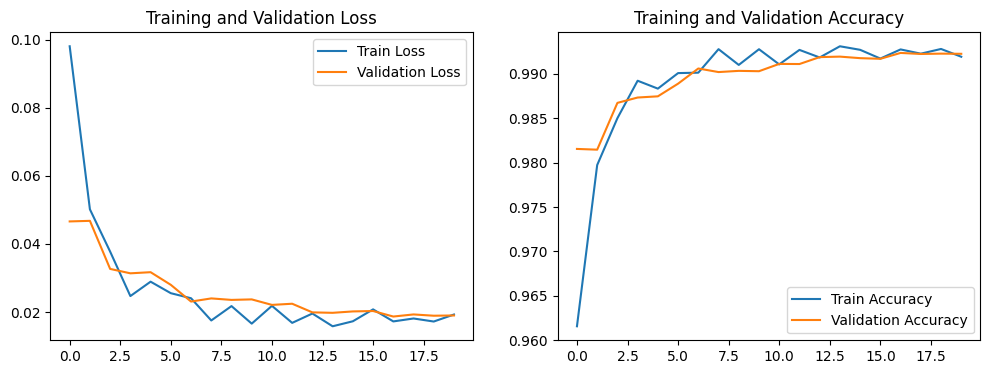

In [ ]:
first_run=False
batch_size = 16
input_shape = (256, 256, 1)
num_classes = 1

# Build your model
model = build_unet(input_shape, num_classes)

if not first_run:
  # Load weights if needed
  model.load_weights(os.path.join(models_dir,'Best_Model.keras'))

# Compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Calculate steps_per_epoch from dataset size and batch size
steps_per_epoch = len(train_image_paths) // batch_size
validation_steps = len(val_image_paths) // batch_size

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    os.path.join(models_dir,'Best_Model.keras'), save_best_only=True, monitor='val_loss', mode='min'
)
early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True, monitor='val_loss', mode='min'
)

# Fit model on dataset generators
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[early_stopping, model_checkpoint]
)

# Plot training progress
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(122)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

# Save final model
model.save(os.path.join(models_dir,'final_unet_model.keras'))


# **Plots**
Randomly plots the image and predicted mask for a sample from each class (**Normal**, **COVID**, **Viral Pneumonia**, and **Lung Opacity**).

Normal
Image Path: /content/data/COVID-19_Radiography_Dataset/Normal/images/Normal-1016.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


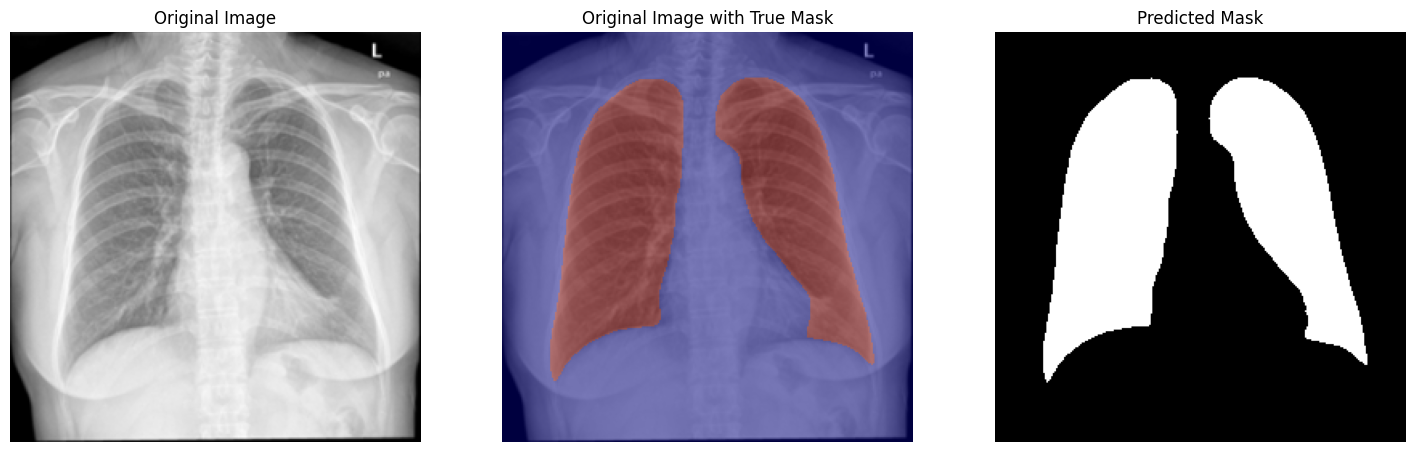


Covid
Image Path: /content/data/COVID-19_Radiography_Dataset/COVID/images/COVID-2214.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


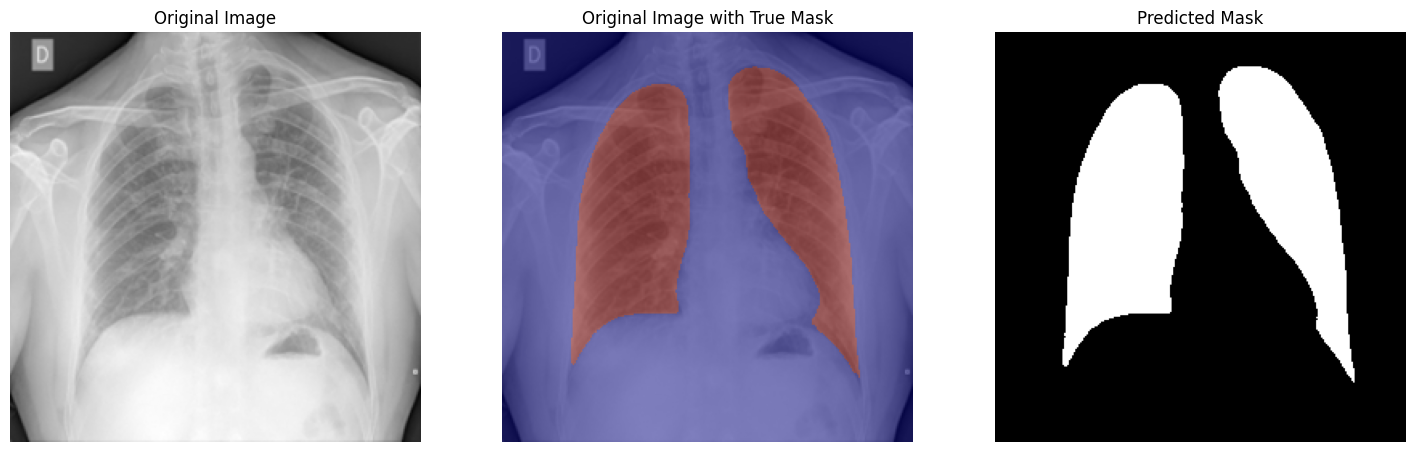


Viral Pneumonia
Image Path: /content/data/COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-545.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


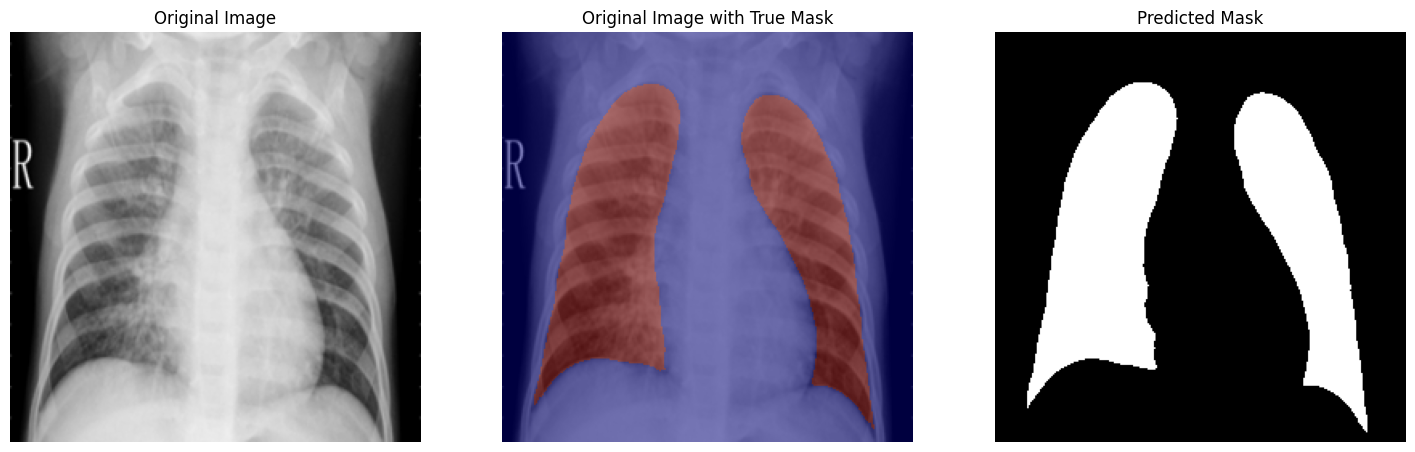


Lung Opacity
Image Path: /content/data/COVID-19_Radiography_Dataset/Lung_Opacity/images/Lung_Opacity-2544.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


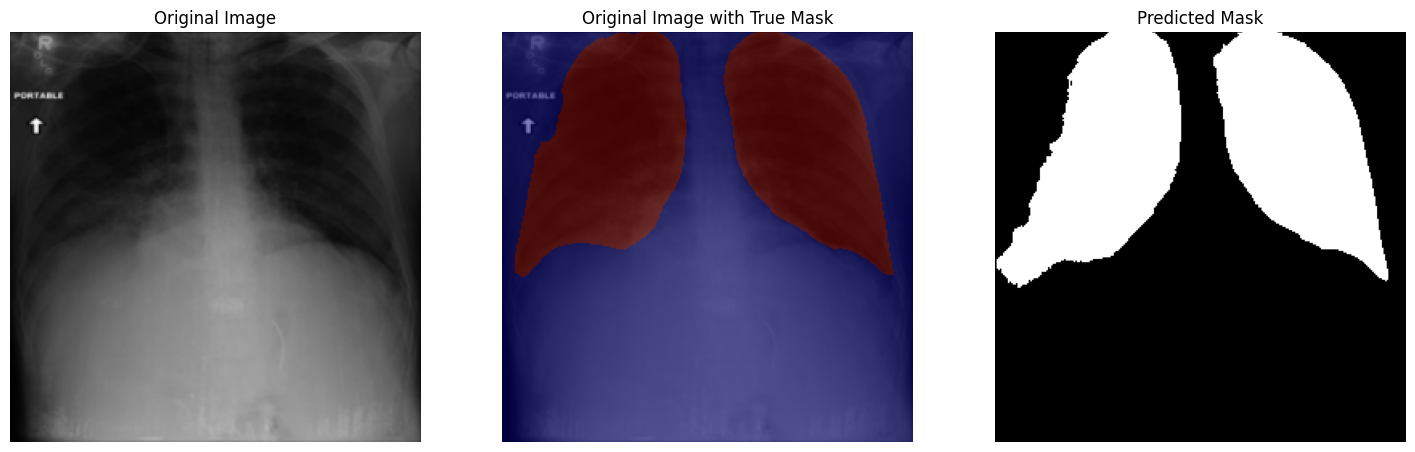

In [8]:
batch_size = 16
input_shape = (256, 256, 1)
num_classes = 1

# Build your model
model = build_unet(input_shape, num_classes)

# Load weights if needed
model.load_weights(os.path.join(models_dir,'Best_Model.keras'))

# Compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
print('Normal')
lung_seg_utils.plot_random_prediction(model, base_dir=main_dir + "/COVID-19_Radiography_Dataset")
print('\nCovid')
lung_seg_utils.plot_random_prediction(model, base_dir=main_dir + "/COVID-19_Radiography_Dataset",category='COVID')
print('\nViral Pneumonia')
lung_seg_utils.plot_random_prediction(model, base_dir=main_dir + "/COVID-19_Radiography_Dataset",category='Viral Pneumonia')
print('\nLung Opacity')
lung_seg_utils.plot_random_prediction(model, base_dir=main_dir + "/COVID-19_Radiography_Dataset",category='Lung_Opacity')



# **Jaccard Similarity and Accuracy For U-Net Model**

In [ ]:
def calculate_jaccard_and_accuracy(model, dataset, threshold=0.5):
    jaccard_scores = []
    accuracies = []

    for images, true_masks in dataset:
        # Predict masks
        preds = model.predict(images,verbose=0)
        # Threshold predictions to binary masks
        preds_binary = (preds >= threshold).astype(np.uint8)

        # Flatten for metric calculation
        preds_flat = preds_binary.flatten()
        true_flat = true_masks.numpy().flatten().astype(np.uint8)

        # Calculate Jaccard (Intersection over Union)
        intersection = np.sum(preds_flat * true_flat)
        union = np.sum(preds_flat) + np.sum(true_flat) - intersection
        jaccard = intersection / union if union > 0 else 1.0

        # Calculate accuracy
        accuracy = np.sum(preds_flat == true_flat) / len(true_flat)

        jaccard_scores.append(jaccard)
        accuracies.append(accuracy)

    mean_jaccard = np.mean(jaccard_scores)
    mean_accuracy = np.mean(accuracies)

    return mean_jaccard, mean_accuracy

# Usage
mean_jaccard, mean_accuracy = calculate_jaccard_and_accuracy(model, test_dataset)
print(f"Test Jaccard Score: {mean_jaccard:.4f}")
print(f"Test Accuracy: {mean_accuracy:.4f}")


Test Jaccard Score: 0.9687
Test Accuracy: 0.9924


# **Plots of Images with Imperfect Predicted Masks**
Some of the predicted masks exhibit inaccuracies. For example, certain masks contain isolated regions disconnected from the main lung area, while others show additional inlets not present in the ground truth masks. Additionally, some predicted masks miss portions of the lung entirely. These imperfections highlight areas where the model could be improved further.

Image Path: /content/data/COVID-19_Radiography_Dataset/Lung_Opacity/images/Lung_Opacity-1252.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 845ms/step


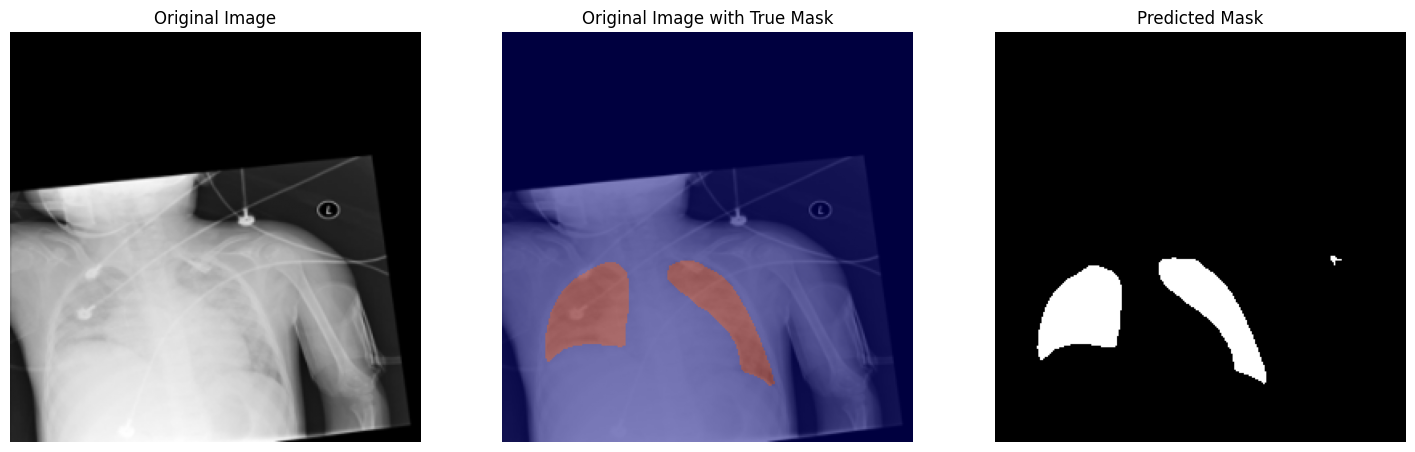

Image Path: /content/data/COVID-19_Radiography_Dataset/COVID/images/COVID-1661.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


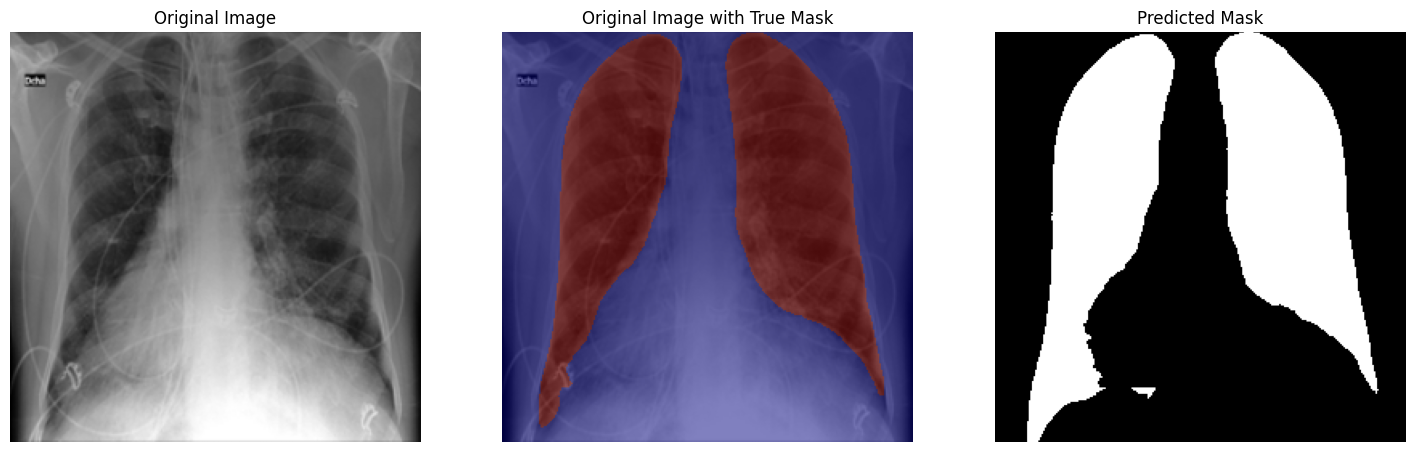

Image Path: /content/data/COVID-19_Radiography_Dataset/COVID/images/COVID-1775.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


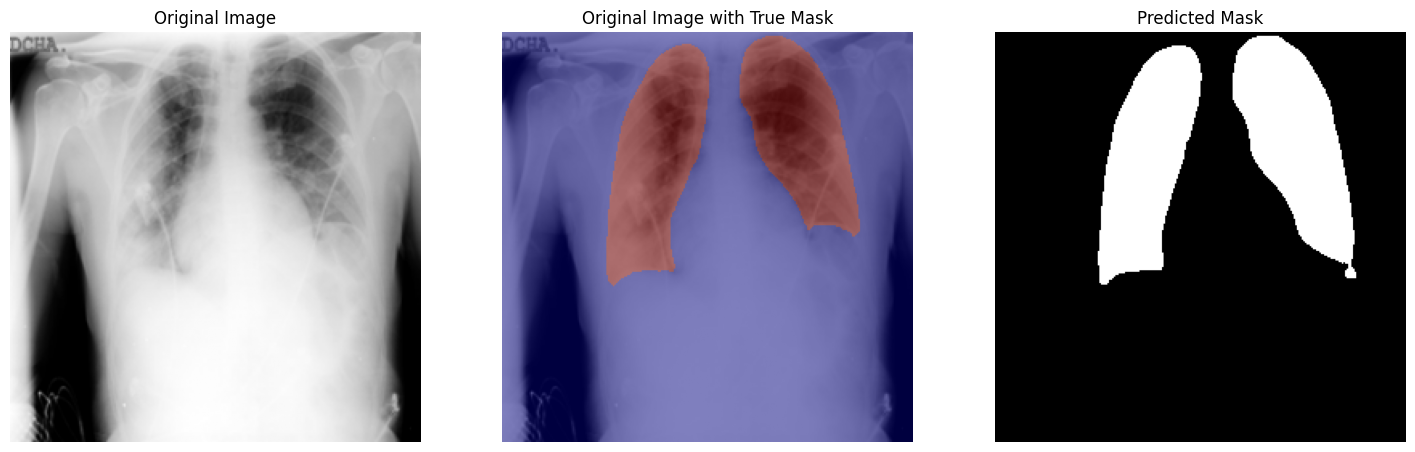

Image Path: /content/data/COVID-19_Radiography_Dataset/Lung_Opacity/images/Lung_Opacity-1479.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


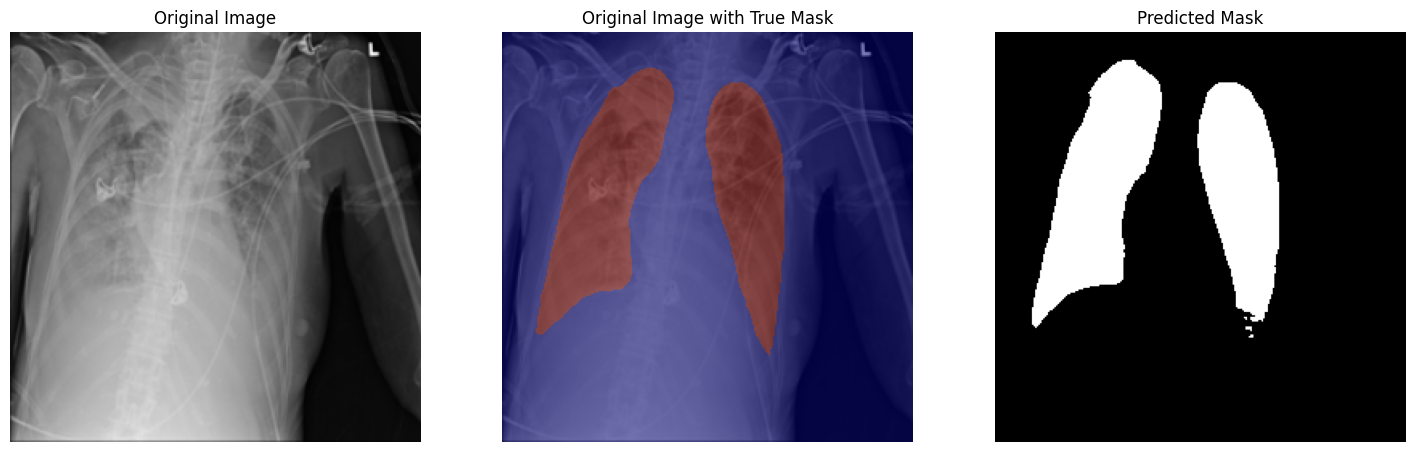

Image Path: /content/data/COVID-19_Radiography_Dataset/Lung_Opacity/images/Lung_Opacity-5895.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


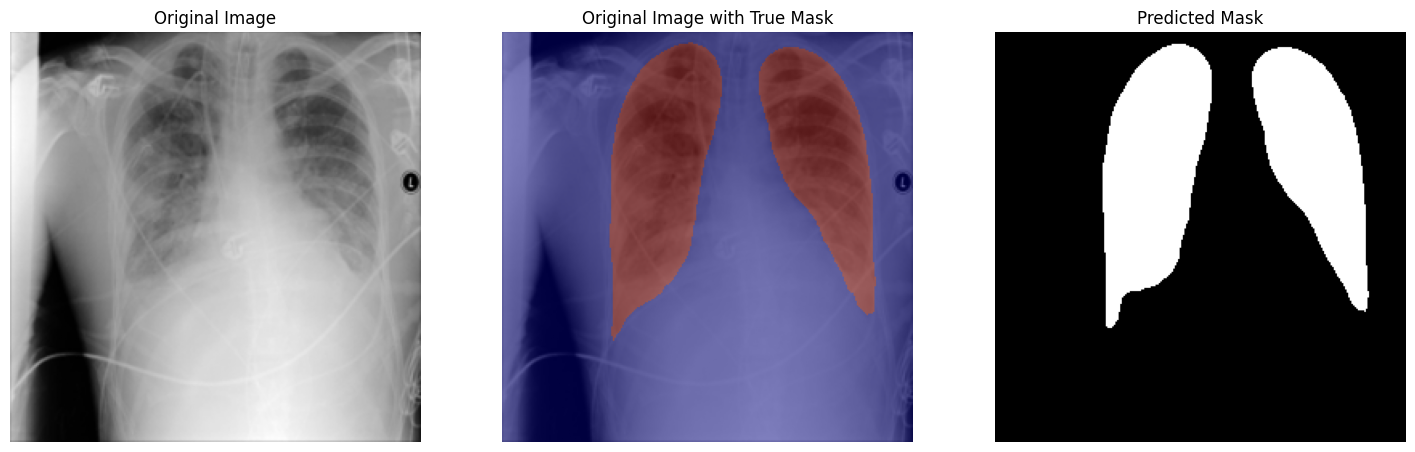

Image Path: /content/data/COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-629.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


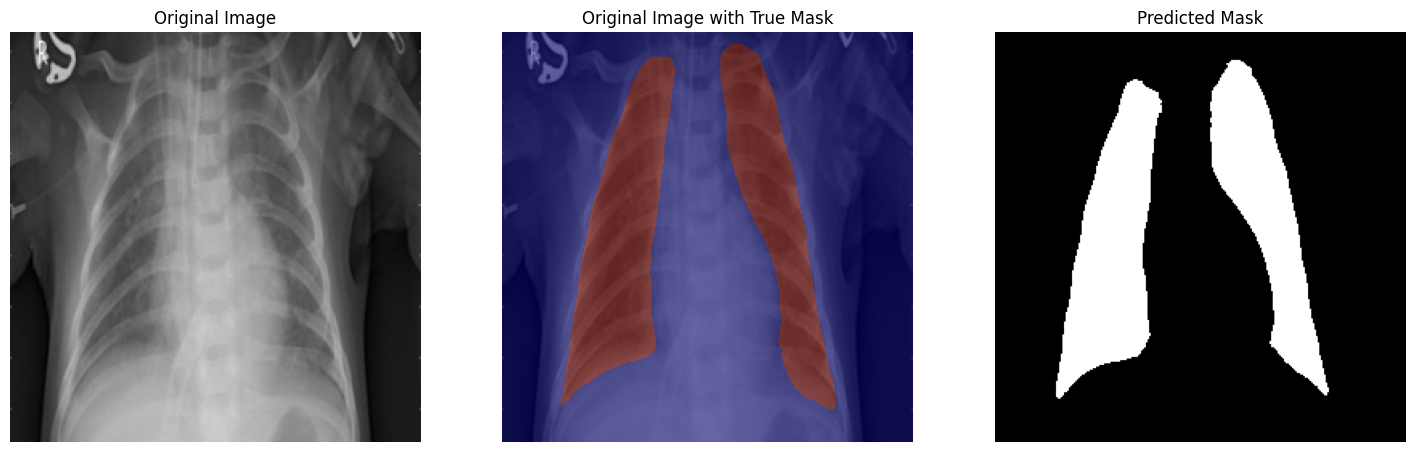

Image Path: /content/data/COVID-19_Radiography_Dataset/Lung_Opacity/images/Lung_Opacity-2208.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


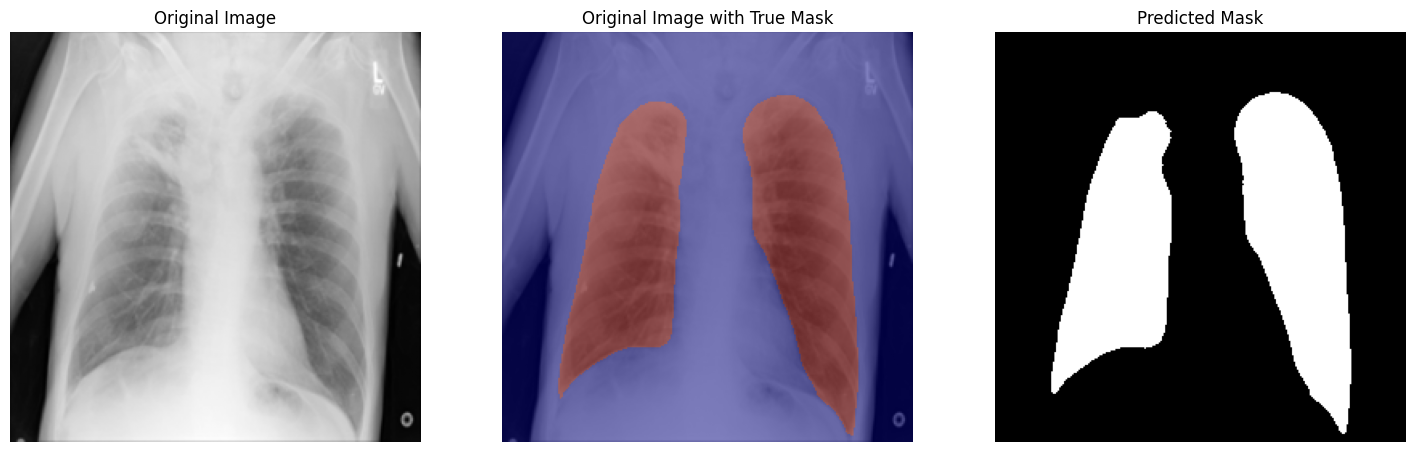

Image Path: /content/data/COVID-19_Radiography_Dataset/Lung_Opacity/images/Lung_Opacity-2974.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


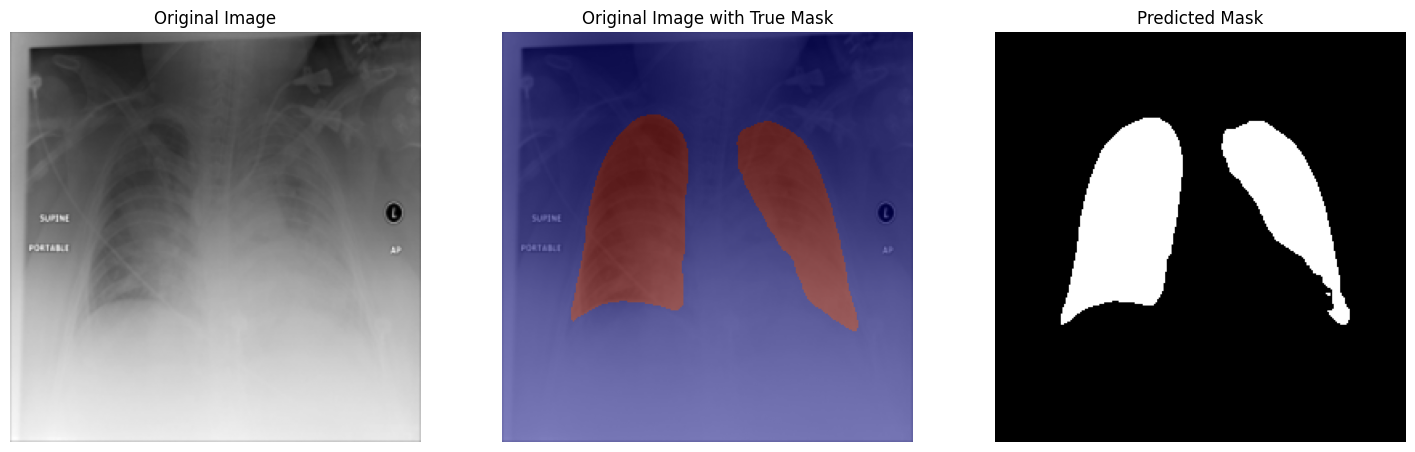

Image Path: /content/data/COVID-19_Radiography_Dataset/Lung_Opacity/images/Lung_Opacity-1884.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


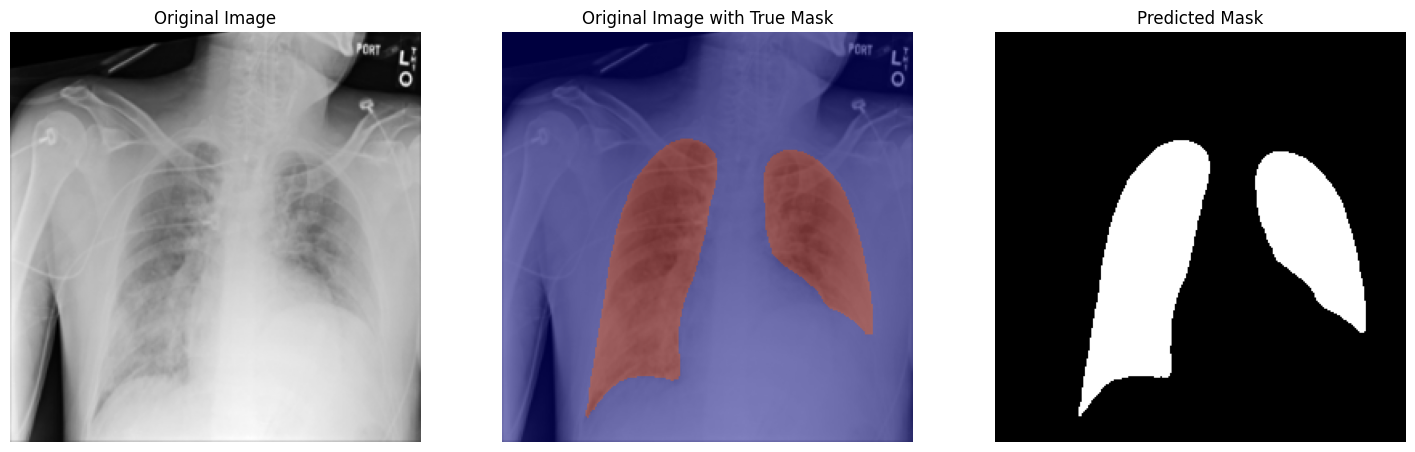

In [10]:
# Build your model
model = build_unet(input_shape, num_classes)

# Load weights if needed
model.load_weights(os.path.join(models_dir,'Best_Model.keras'))

# Compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

problematic_files = ['Lung_Opacity-1252.png', 'COVID-1661.png', 'COVID-1775.png', 'Lung_Opacity-1479.png', 'Lung_Opacity-5895.png',
'Viral Pneumonia-629.png','Lung_Opacity-2208.png','Lung_Opacity-2974.png','Lung_Opacity-1884.png']

for fname in problematic_files:
    # Extract category from filename prefix
    category = fname.split('-')[0]
    image_dir = os.path.join(main_dir, "COVID-19_Radiography_Dataset", category, "images")
    mask_dir = os.path.join(main_dir, "COVID-19_Radiography_Dataset", category, "masks")

    lung_seg_utils.plot_specific_prediction(
        model,
        image_dir=image_dir,
        mask_dir=mask_dir,
        image_filename=fname,
        mask_filename=fname
    )


# **Refining with Generative Adversarial Network (GAN)**
- Generator starts as `Best_Model.keras`
- Discriminator is randomly initialized

In [32]:
def build_discriminator(input_shape=(256, 256, 1)):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, 4, strides=2, padding='same')(inputs)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Conv2D(128, 4, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Conv2D(256, 4, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Conv2D(512, 4, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.2)(x)
    x = layers.Conv2D(1, 4, strides=1, padding='same')(x)
    outputs = layers.Activation('sigmoid')(x)  # Probability of real/fake
    return models.Model(inputs, outputs, name='discriminator')
first_run=False
# Dimensions and model construction
input_shape = (256, 256, 1)
num_classes = 1

generator = build_unet(input_shape, num_classes)
if first_run:
  generator.load_weights(os.path.join(models_dir, 'Best_Model.keras'))
else:
  generator.load_weights(os.path.join(models_dir, 'best_generator_gan_model.keras'))
discriminator = build_discriminator(input_shape)

# Define optimizers
gen_optimizer = optimizers.Adam(learning_rate=1e-4)
disc_optimizer = optimizers.Adam(learning_rate=1e-4)

# Loss functions
bce = losses.BinaryCrossentropy(from_logits=False)
mse = losses.MeanSquaredError()

@tf.function
def train_step(images, masks):
    # Forward call to get discriminator output to infer shape
    disc_out_shape = discriminator(masks, training=True).shape[1:]

    real_labels = tf.ones((tf.shape(images)[0], *disc_out_shape))
    fake_labels = tf.zeros((tf.shape(images)[0], *disc_out_shape))

    with tf.GradientTape(persistent=True) as tape:
        generated_masks = generator(images, training=True)

        real_output = discriminator(masks, training=True)
        fake_output = discriminator(generated_masks, training=True)

        gen_adv_loss = bce(real_labels, fake_output)
        gen_l1_loss = tf.reduce_mean(tf.abs(masks - generated_masks))
        gen_loss = gen_adv_loss + 100 * gen_l1_loss

        disc_real_loss = bce(real_labels, real_output)
        disc_fake_loss = bce(fake_labels, fake_output)
        disc_loss = (disc_real_loss + disc_fake_loss) * 0.5

    gen_gradients = tape.gradient(gen_loss, generator.trainable_variables)
    disc_gradients = tape.gradient(disc_loss, discriminator.trainable_variables)

    gen_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    disc_optimizer.apply_gradients(zip(disc_gradients, discriminator.trainable_variables))

    return gen_loss, disc_loss


def validate(model, val_dataset):
    iou_metric = MeanIoU(num_classes=2)
    for images, masks in val_dataset:
        preds = model.predict(images)
        preds = (preds > 0.5).astype('int32')
        masks = masks.numpy().astype('int32')
        iou_metric.update_state(masks, preds)
    return iou_metric.result().numpy()

def train(dataset, val_dataset, epochs, patience=5):
    best_iou = 0
    epochs_without_improvement = 0
    for epoch in range(epochs):
        # Training loop (as before)
        for batch, (images, masks) in enumerate(dataset):
            gen_loss, disc_loss = train_step(images, masks)
            if batch % 10 == 0:
                print(f"Epoch {epoch+1} Batch {batch} Gen loss: {gen_loss.numpy():.4f} Disc loss: {disc_loss.numpy():.4f}")

        # Validate
        val_iou = validate(generator, val_dataset)
        print(f"Epoch {epoch+1} Validation IoU: {val_iou:.4f}")

        # Early stopping check
        if val_iou > best_iou:
            best_iou = val_iou
            epochs_without_improvement = 0
            # Save best weights
            generator.save(os.path.join(models_dir, 'best_generator_gan_model.keras'))
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"No improvement for {patience} epochs, stopping training.")
                break

train(train_dataset, val_dataset, epochs=20, patience=5)
# Assume generator is your trained generator model
save_path = os.path.join(models_dir, 'generator_gan_model_run2.keras')

# Save the model in TensorFlow's native format
generator.save(save_path)

print(f"Generator model saved to {save_path}")




/usr/local/lib/python3.12/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1 Batch 0 Gen loss: 1.3473 Disc loss: 0.7726
Epoch 1 Batch 10 Gen loss: 1.2438 Disc loss: 0.7316
Epoch 1 Batch 20 Gen loss: 1.3351 Disc loss: 0.7024
Epoch 1 Batch 30 Gen loss: 1.1575 Disc loss: 0.6988
Epoch 1 Batch 40 Gen loss: 1.3230 Disc loss: 0.6963
Epoch 1 Batch 50 Gen loss: 1.5921 Disc loss: 0.6953
Epoch 1 Batch 60 Gen loss: 1.1407 Disc loss: 0.6948
Epoch 1 Batch 70 Gen loss: 1.3086 Disc loss: 0.6946
Epoch 1 Batch 80 Gen loss: 1.2602 Disc loss: 0.6943
Epoch 1 Batch 90 Gen loss: 1.3791 Disc loss: 0.6944
Epoch 1 Batch 100 Gen loss: 1.3769 Disc loss: 0.6943
Epoch 1 Batch 110 Gen loss: 1.5036 Disc loss: 0.6940
Epoch 1 Batch 120 Gen loss: 1.3736 Disc loss: 0.6937
Epoch 1 Batch 130 Gen loss: 1.2413 Disc loss: 0.6939
Epoch 1 Batch 140 Gen loss: 1.1761 Disc loss: 0.6938
Epoch 1 Batch 150 Gen loss: 1.2557 Disc loss: 0.6938
Epoch 1 Batch 160 Gen loss: 1.4100 Disc loss: 0.6936
Epoch 1 Batch 170 Gen loss: 1.2619 Disc loss: 0.6937
Epoch 1 Batch 180 Gen loss: 1.2944 Disc loss: 0.6935
Epoc

# **Jaccard Similarity and Accuracy after GAN refinement**

In [10]:
input_shape = (256, 256, 1)
num_classes = 1
# Usage
# Build your model
model = build_unet(input_shape, num_classes)

# Load weights if needed
model.load_weights(os.path.join(models_dir, 'generator_gan_model_run2.keras'))

# Compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
mean_jaccard, mean_accuracy = calculate_jaccard_and_accuracy(model, test_dataset)
print(f"Test Jaccard Score: {mean_jaccard:.4f}")
print(f"Test Accuracy: {mean_accuracy:.4f}")

Test Jaccard Score: 0.9757
Test Accuracy: 0.9941


# **Plots of Images with Imperfect Predicted Masks (After GAN)**

Image Path: /content/data/COVID-19_Radiography_Dataset/Lung_Opacity/images/Lung_Opacity-1252.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 876ms/step


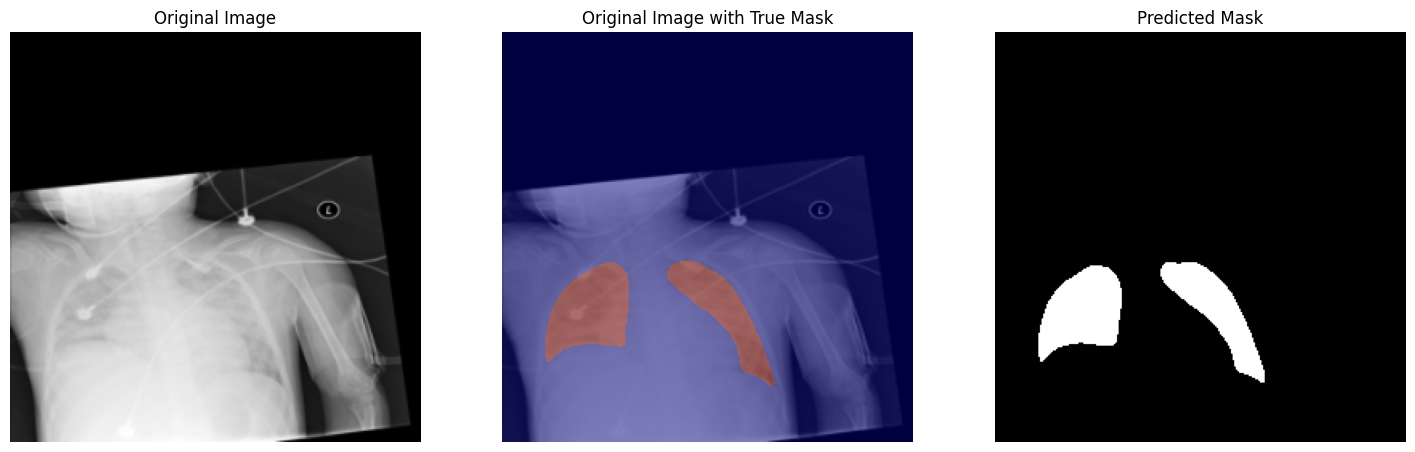

Image Path: /content/data/COVID-19_Radiography_Dataset/COVID/images/COVID-1661.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


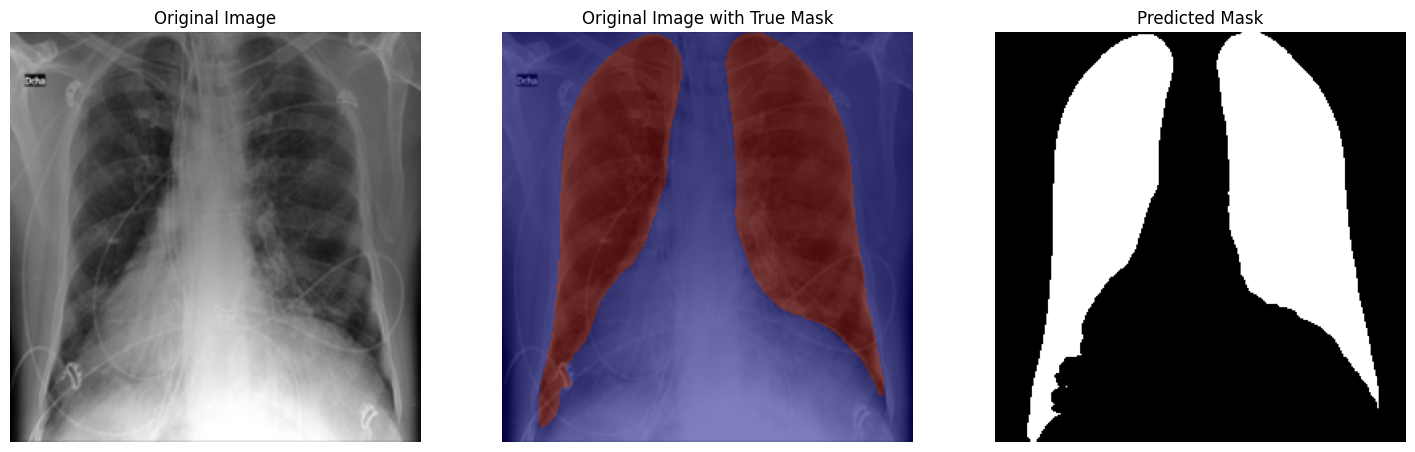

Image Path: /content/data/COVID-19_Radiography_Dataset/COVID/images/COVID-1775.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


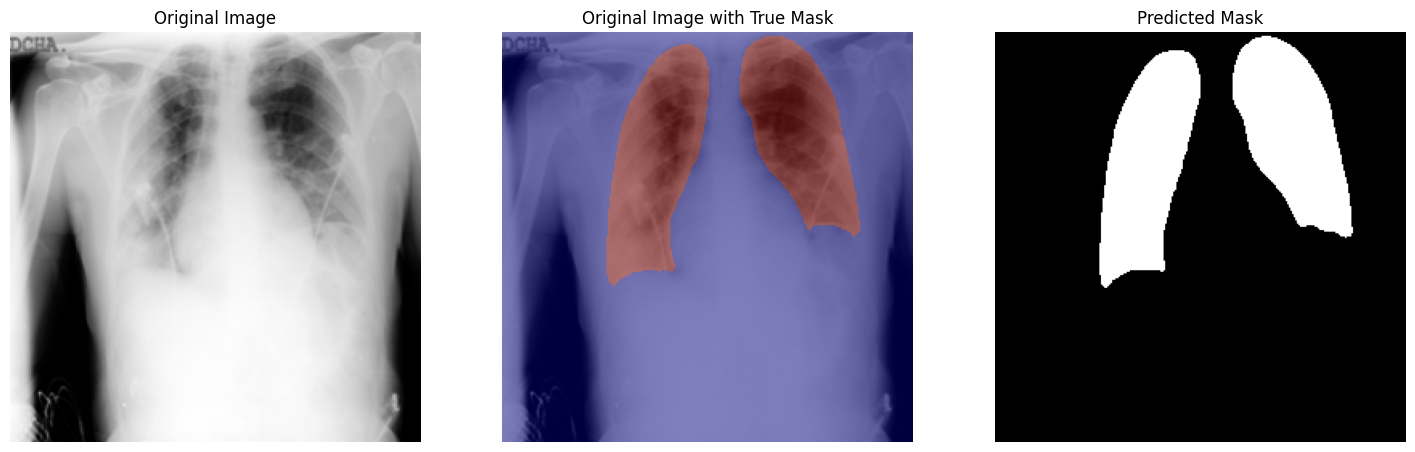

Image Path: /content/data/COVID-19_Radiography_Dataset/Lung_Opacity/images/Lung_Opacity-1479.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


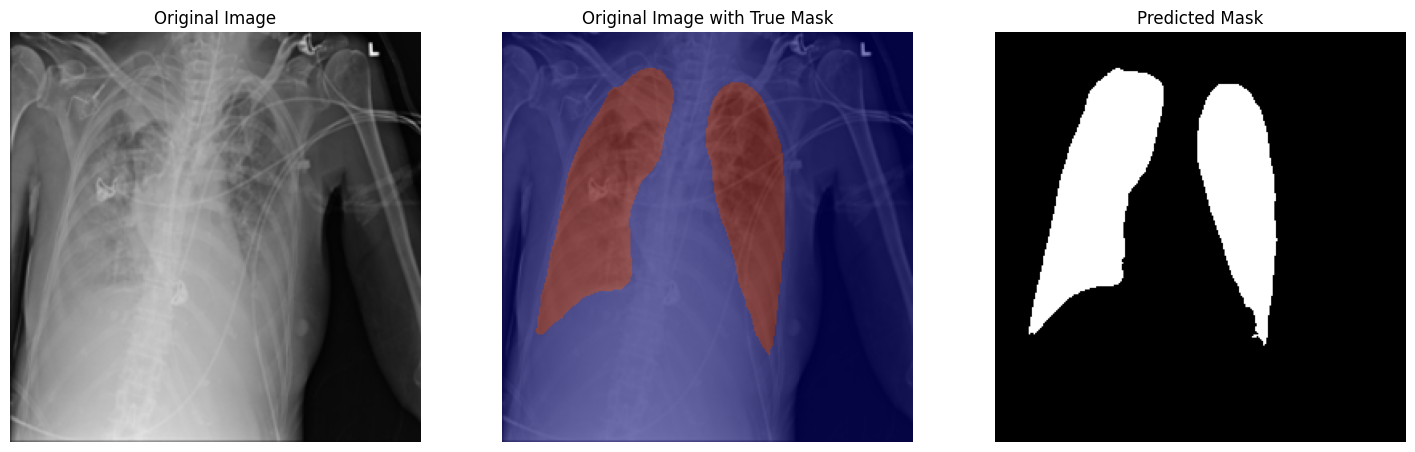

Image Path: /content/data/COVID-19_Radiography_Dataset/Lung_Opacity/images/Lung_Opacity-5895.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


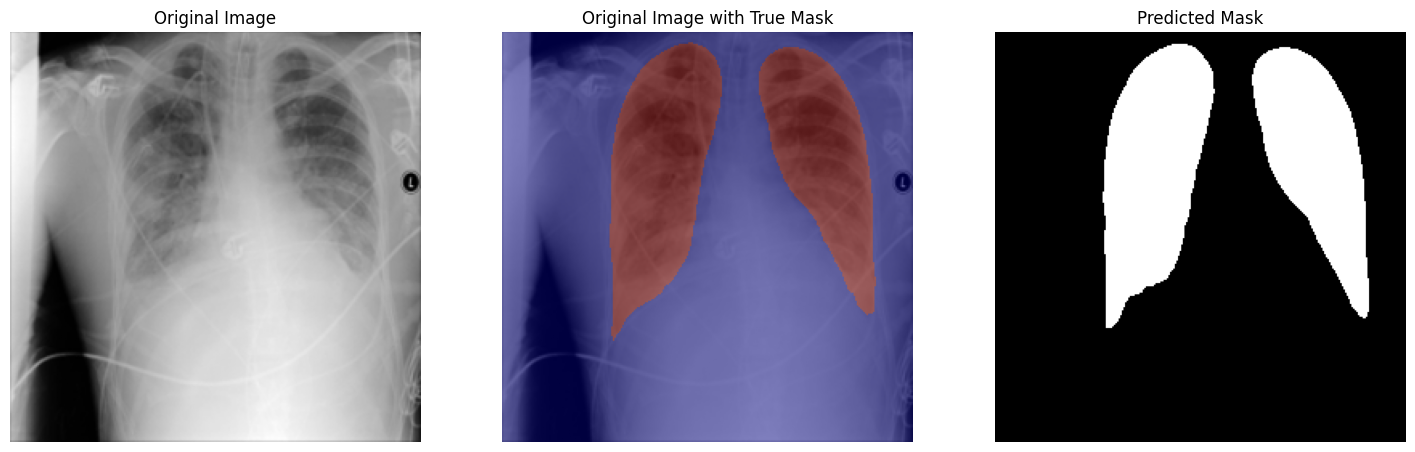

Image Path: /content/data/COVID-19_Radiography_Dataset/Viral Pneumonia/images/Viral Pneumonia-629.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


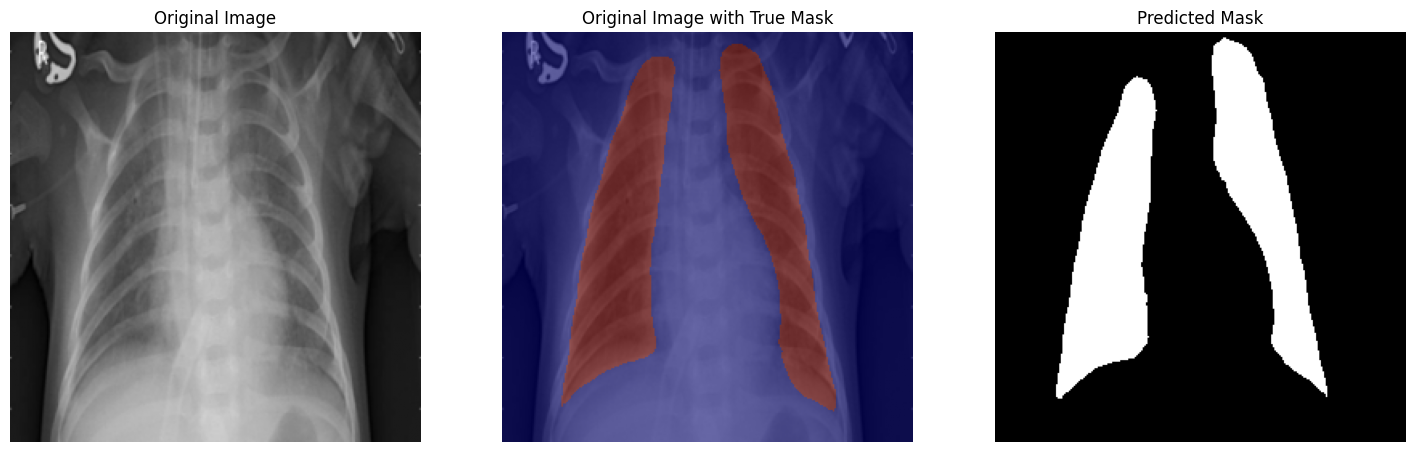

Image Path: /content/data/COVID-19_Radiography_Dataset/Lung_Opacity/images/Lung_Opacity-2208.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


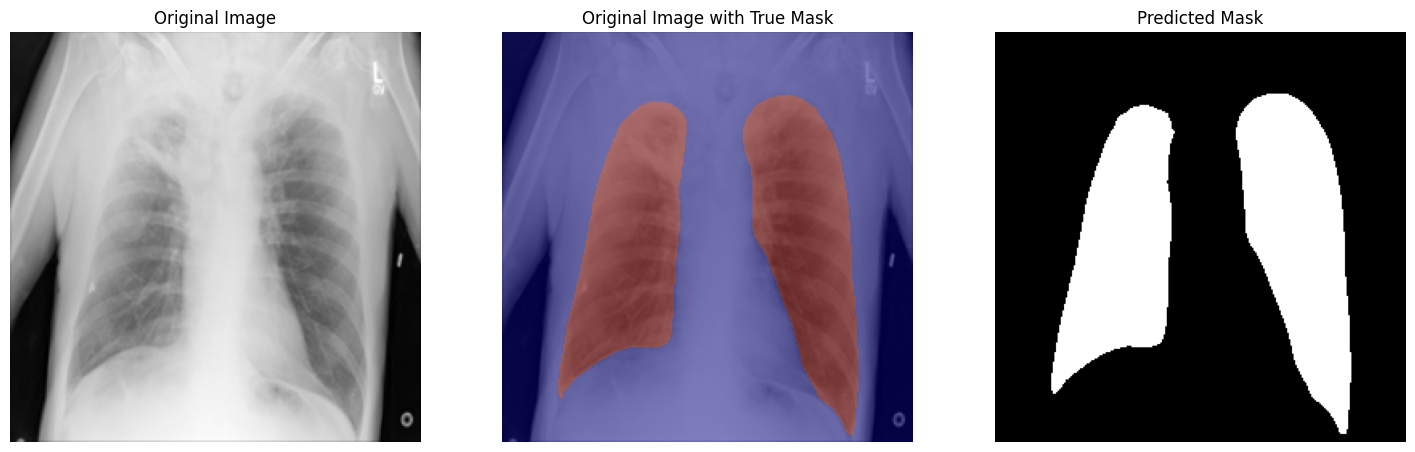

Image Path: /content/data/COVID-19_Radiography_Dataset/Lung_Opacity/images/Lung_Opacity-2974.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


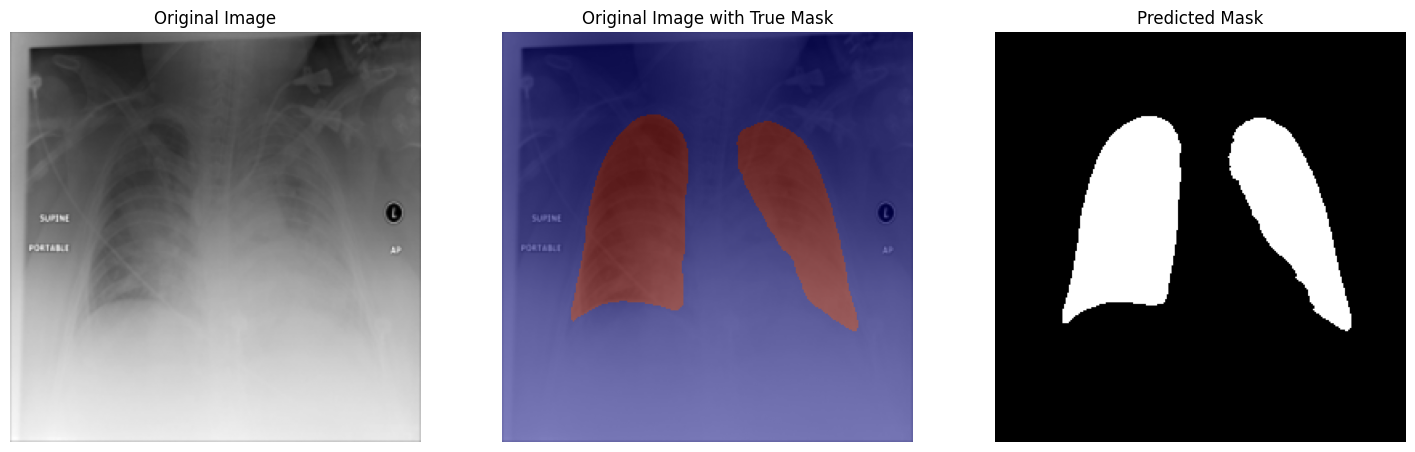

Image Path: /content/data/COVID-19_Radiography_Dataset/Lung_Opacity/images/Lung_Opacity-1884.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


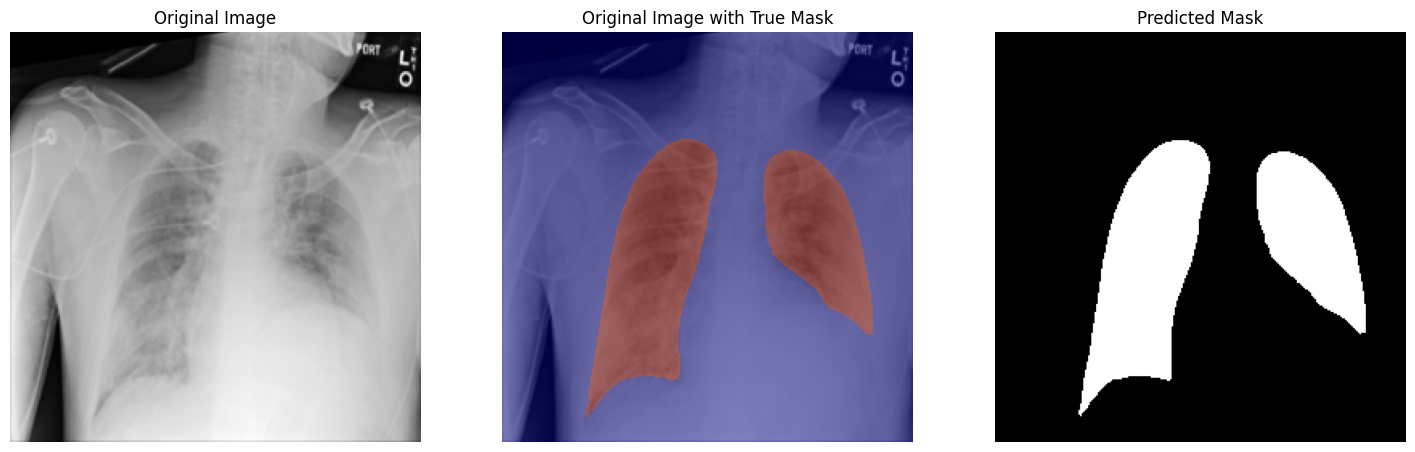

In [15]:
# Build your model
model = build_unet(input_shape, num_classes)

# Load weights if needed
model.load_weights(os.path.join(models_dir, 'generator_gan_model_run2.keras'))
#model.load_weights(os.path.join(data_dir, 'best_generator_gan_model.keras'))


# Compile
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

for fname in problematic_files:
    # Extract category from filename prefix
    category = fname.split('-')[0]
    image_dir = os.path.join(main_dir, "COVID-19_Radiography_Dataset", category, "images")
    mask_dir = os.path.join(main_dir, "COVID-19_Radiography_Dataset", category, "masks")

    lung_seg_utils.plot_specific_prediction(
        model,
        image_dir=image_dir,
        mask_dir=mask_dir,
        image_filename=fname,
        mask_filename=fname
    )